In [226]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

In [227]:
## Read the dataset
df = pd.read_csv("heart.csv")

In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 11 columns):
row          462 non-null int64
sbp          462 non-null int64
tobacco      462 non-null float64
ldl          462 non-null float64
adiposity    462 non-null float64
famhist      462 non-null object
typea        462 non-null int64
obesity      462 non-null float64
alcohol      462 non-null float64
age          462 non-null int64
chd          462 non-null int64
dtypes: float64(5), int64(5), object(1)
memory usage: 39.8+ KB


In [229]:
df.head()

,row,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,1,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,2,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,3,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,4,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,5,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [230]:
##one hot encode famhist
df1 = pd.get_dummies(df,prefix=['famhist'])

In [231]:
##drop row column and chd column as this will be our label
df1 = df1.drop("row",axis=1)
df1 = df1.drop("chd",axis=1)
df1.head()

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,famhist_Absent,famhist_Present
0,160,12.00,5.73,23.11,49,25.30,97.20,52,0,1
1,144,0.01,4.41,28.61,55,28.87,2.06,63,1,0
2,118,0.08,3.48,32.28,52,29.14,3.81,46,0,1
3,170,7.50,6.41,38.03,51,31.99,24.26,58,0,1
4,134,13.60,3.50,27.78,60,25.99,57.34,49,0,1


In [232]:
##lets store attributes from sbp to age in a buffer dataframe
df_buf = df1.loc[:,:"age"]
##normalize attributes from sbp to age
df_norm = (df_buf - df_buf.mean()) / (df_buf.max() - df_buf.min())
##add famhist column
df_norm["famhist_Absent"] = df1["famhist_Absent"]
df_norm["famhist_Present"] = df1["famhist_Present"]

In [233]:
##this is how the normalized input looks like now
df_norm.head()

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,famhist_Absent,famhist_Present
0,0.185241,0.268088,0.068967,-0.064244,-0.063137,-0.023341,0.544572,0.187428,0,1
1,0.048489,-0.116207,-0.023019,0.089602,0.029171,0.088641,-0.101803,0.411918,1,0
2,-0.173734,-0.113963,-0.087828,0.192259,-0.016983,0.097111,-0.089914,0.064979,0,1
3,0.270711,0.123857,0.116354,0.353098,-0.032368,0.186508,0.049022,0.309877,0,1
4,-0.036982,0.319370,-0.086434,0.066385,0.106094,-0.001697,0.273766,0.126204,0,1


In [234]:
##df_data is our input space
df_data = df_norm

##df_label is our output space
df_label = np.array(df["chd"])

##one hot encode the output_space
nb_classes = 2
df_label = np.eye(nb_classes)[df_label]

##split into test and train dataset
data_train, data_test, label_train, label_test = train_test_split(df_data, df_label, test_size=0.2, random_state=42)

In [235]:
##lets check the shape of our data space
print(data_train.shape)
print(label_train.shape)
print(data_test.shape)
print(label_test.shape)

(369, 10)
(369, 2)
(93, 10)
(93, 2)


In [248]:
# define parameters for training
learning_rate = 0.1
training_epochs = 500
display_step = 10
input_size = data_train.shape[1] ##this is the number of input features
output_size = label_train.shape[1] ##number of output columns

In [249]:
# tf Graph Input
x = tf.placeholder(tf.float32, [None, input_size]) 
y = tf.placeholder(tf.float32, [None, output_size])

# Set model weight and bias
W = tf.Variable(tf.random_normal([input_size,output_size],mean=0.0,stddev=10.0, dtype=tf.float32))
b = tf.Variable(tf.random_normal([output_size],mean=0.0,stddev=10.0, dtype=tf.float32))

In [250]:
# Construct model
logits = tf.matmul(x, W) + b ##this is linear regression
pred = tf.nn.softmax(logits) # Softmax

#cross entropy error
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

##adam optimizer
optimizer =  tf.train.AdamOptimizer(learning_rate).minimize(cost) 

In [251]:
# no of correct prediction
correct_prediction = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))

# Calculate accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [252]:
# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

In [253]:
sess1 = tf.Session()
# Run the initializer
sess1.run(init)

accuracy_list = []
cost_list = []
# Training cycle
for epoch in range(training_epochs):
    avg_cost = 0.
    # Run optimization op (backprop) and cost op (to get loss value)
    _, c = sess1.run([optimizer, cost], feed_dict={x: data_train, y: label_train})
    
    #calculate accuracy on train set
    acc = sess1.run(accuracy,feed_dict = {x: data_train, y: label_train})
    
    # store c and acc
    accuracy_list.append(acc)
    cost_list.append(c)
    
    # Display logs per epoch step
    if (epoch+1) % display_step == 0:
        print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
        print ("accuracy: ",acc)

print("Optimization Finished!")

Epoch: 0010 cost= 5.260790348
accuracy:  0.644986
Epoch: 0020 cost= 4.322918892
accuracy:  0.642276
Epoch: 0030 cost= 3.398313046
accuracy:  0.644986
Epoch: 0040 cost= 2.574938297
accuracy:  0.655827
Epoch: 0050 cost= 2.007414579
accuracy:  0.696477
Epoch: 0060 cost= 1.624600053
accuracy:  0.696477
Epoch: 0070 cost= 1.317111135
accuracy:  0.704607
Epoch: 0080 cost= 1.057352662
accuracy:  0.712737
Epoch: 0090 cost= 0.838811219
accuracy:  0.720867
Epoch: 0100 cost= 0.676279068
accuracy:  0.718157
Epoch: 0110 cost= 0.578028619
accuracy:  0.723577
Epoch: 0120 cost= 0.530993521
accuracy:  0.718157
Epoch: 0130 cost= 0.516275406
accuracy:  0.734417
Epoch: 0140 cost= 0.515413821
accuracy:  0.723577
Epoch: 0150 cost= 0.514650226
accuracy:  0.731707
Epoch: 0160 cost= 0.514127314
accuracy:  0.739837
Epoch: 0170 cost= 0.514072597
accuracy:  0.737127
Epoch: 0180 cost= 0.514001966
accuracy:  0.734417
Epoch: 0190 cost= 0.513973355
accuracy:  0.726287
Epoch: 0200 cost= 0.513975441
accuracy:  0.723577


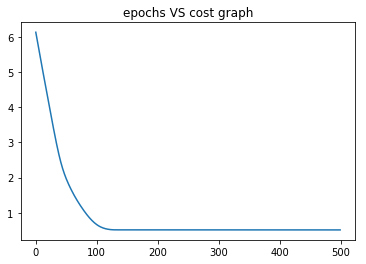

In [256]:
## lets check when our model converged
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1)

Xaxis = [i for i in range(training_epochs)]
ax.plot(Xaxis,cost_list)
plt.title("epochs VS cost graph")
plt.show()

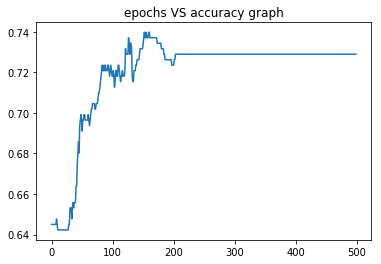

In [257]:
## plot epoch vs vs accuracy graph
fig,ax = plt.subplots(1)
ax.plot(Xaxis,accuracy_list)
plt.title("epochs VS accuracy graph")
plt.show()

In [254]:
##run it on test Set and check the accuracy
prd = sess1.run(pred,feed_dict = {x: data_test, y: label_test})
acc1 = sess1.run(accuracy,feed_dict = {x: data_test, y: label_test})
print ("accuracy on test set: ",acc1)

accuracy on test set:  0.784946
